In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, auc, roc_curve, roc_auc_score

from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.linear_model import LassoCV

# Loading Data

In [2]:
data = pd.read_csv('./data_processed/data_first_record_with_commorbidities.csv', index_col=0)
data.fillna(data.mean(), inplace=True)
data.los = (data.los > 4).astype(int)

In [3]:
X = data.loc[:, data.columns != 'los']
y = data.loc[:, data.columns == 'los']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost

## Binary Outcome

In [5]:
xg_clf = xgb.XGBClassifier(objective ='binary:logistic')

### Find Parameters

#### GridSearch

In [6]:
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.05],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0]
}

model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

grid_search = GridSearchCV(estimator=model, 
                           param_grid=param_grid, 
                           scoring='accuracy', 
                           cv=3, 
                           verbose=1,)

grid_search.fit(X_train, y_train)

print(f"Best parameters found: {grid_search.best_params_}")

y_pred = grid_search.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy with best parameters: {accuracy * 100.0}")

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters found: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Accuracy with best parameters: 78.62595419847328


### Final Model

In [7]:
final_model = xgb.XGBClassifier(**grid_search.best_params_)

final_model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [8]:
y_pred = final_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy with best parameters: {accuracy * 100.0}")

Accuracy with best parameters: 85.49618320610686


### ROC Curve

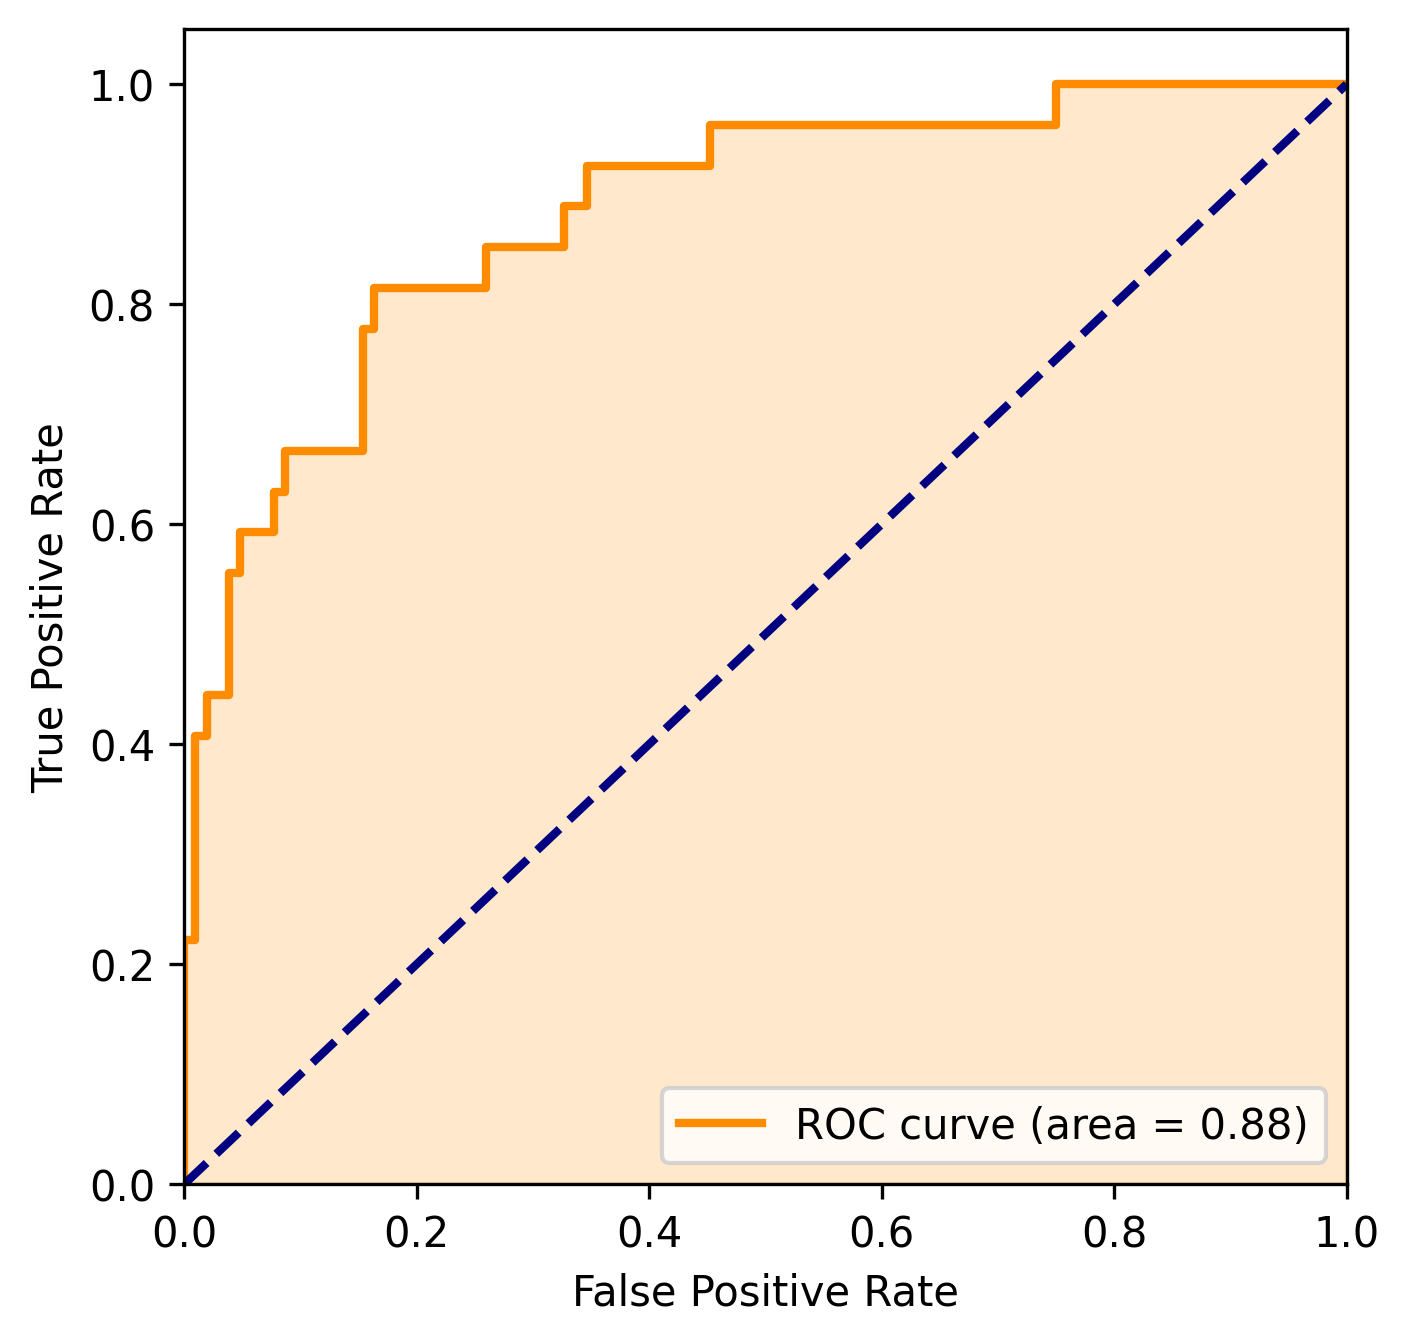

In [9]:
y_scores = final_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_scores)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 5), dpi=300)

plt.plot(fpr, 
         tpr, 
         color='darkorange', 
         lw=2, 
         label=f'ROC curve (area = {roc_auc:.2f})')

plt.fill_between(fpr, tpr, color='darkorange', alpha=0.2)  # alpha 参数控制填充颜色的透明度


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

### Imporpant Matrix

In [10]:
importances = final_model.feature_importances_

feature_names = X.columns

importance_df = (
    pd.DataFrame(importances, index=feature_names, columns=['Importance'])
   .sort_values(by='Importance', ascending=False)
   .reset_index()
)

print(importance_df)


                                     index  Importance
0                Acute respiratory failure    0.104728
1                   marital_status_WIDOWED    0.050440
2                         Thrombocytopenia    0.047067
3                 Congestive heart failure    0.043896
4        Hyposmolality and/or hyponatremia    0.039995
5                  Urinary tract infection    0.038375
6                            Severe sepsis    0.036261
7                         respiratory_rate    0.035984
8                                   gender    0.032088
9                               heart_rate    0.031304
10                              hemoglobin    0.030853
11                    race_HISPANIC/LATINO    0.029990
12         Personal history of tobacco use    0.029867
13                                     mch    0.029394
14                                platelet    0.028025
15                      insurance_Medicare    0.027732
16       Other finger(s) amputation status    0.027667
17        

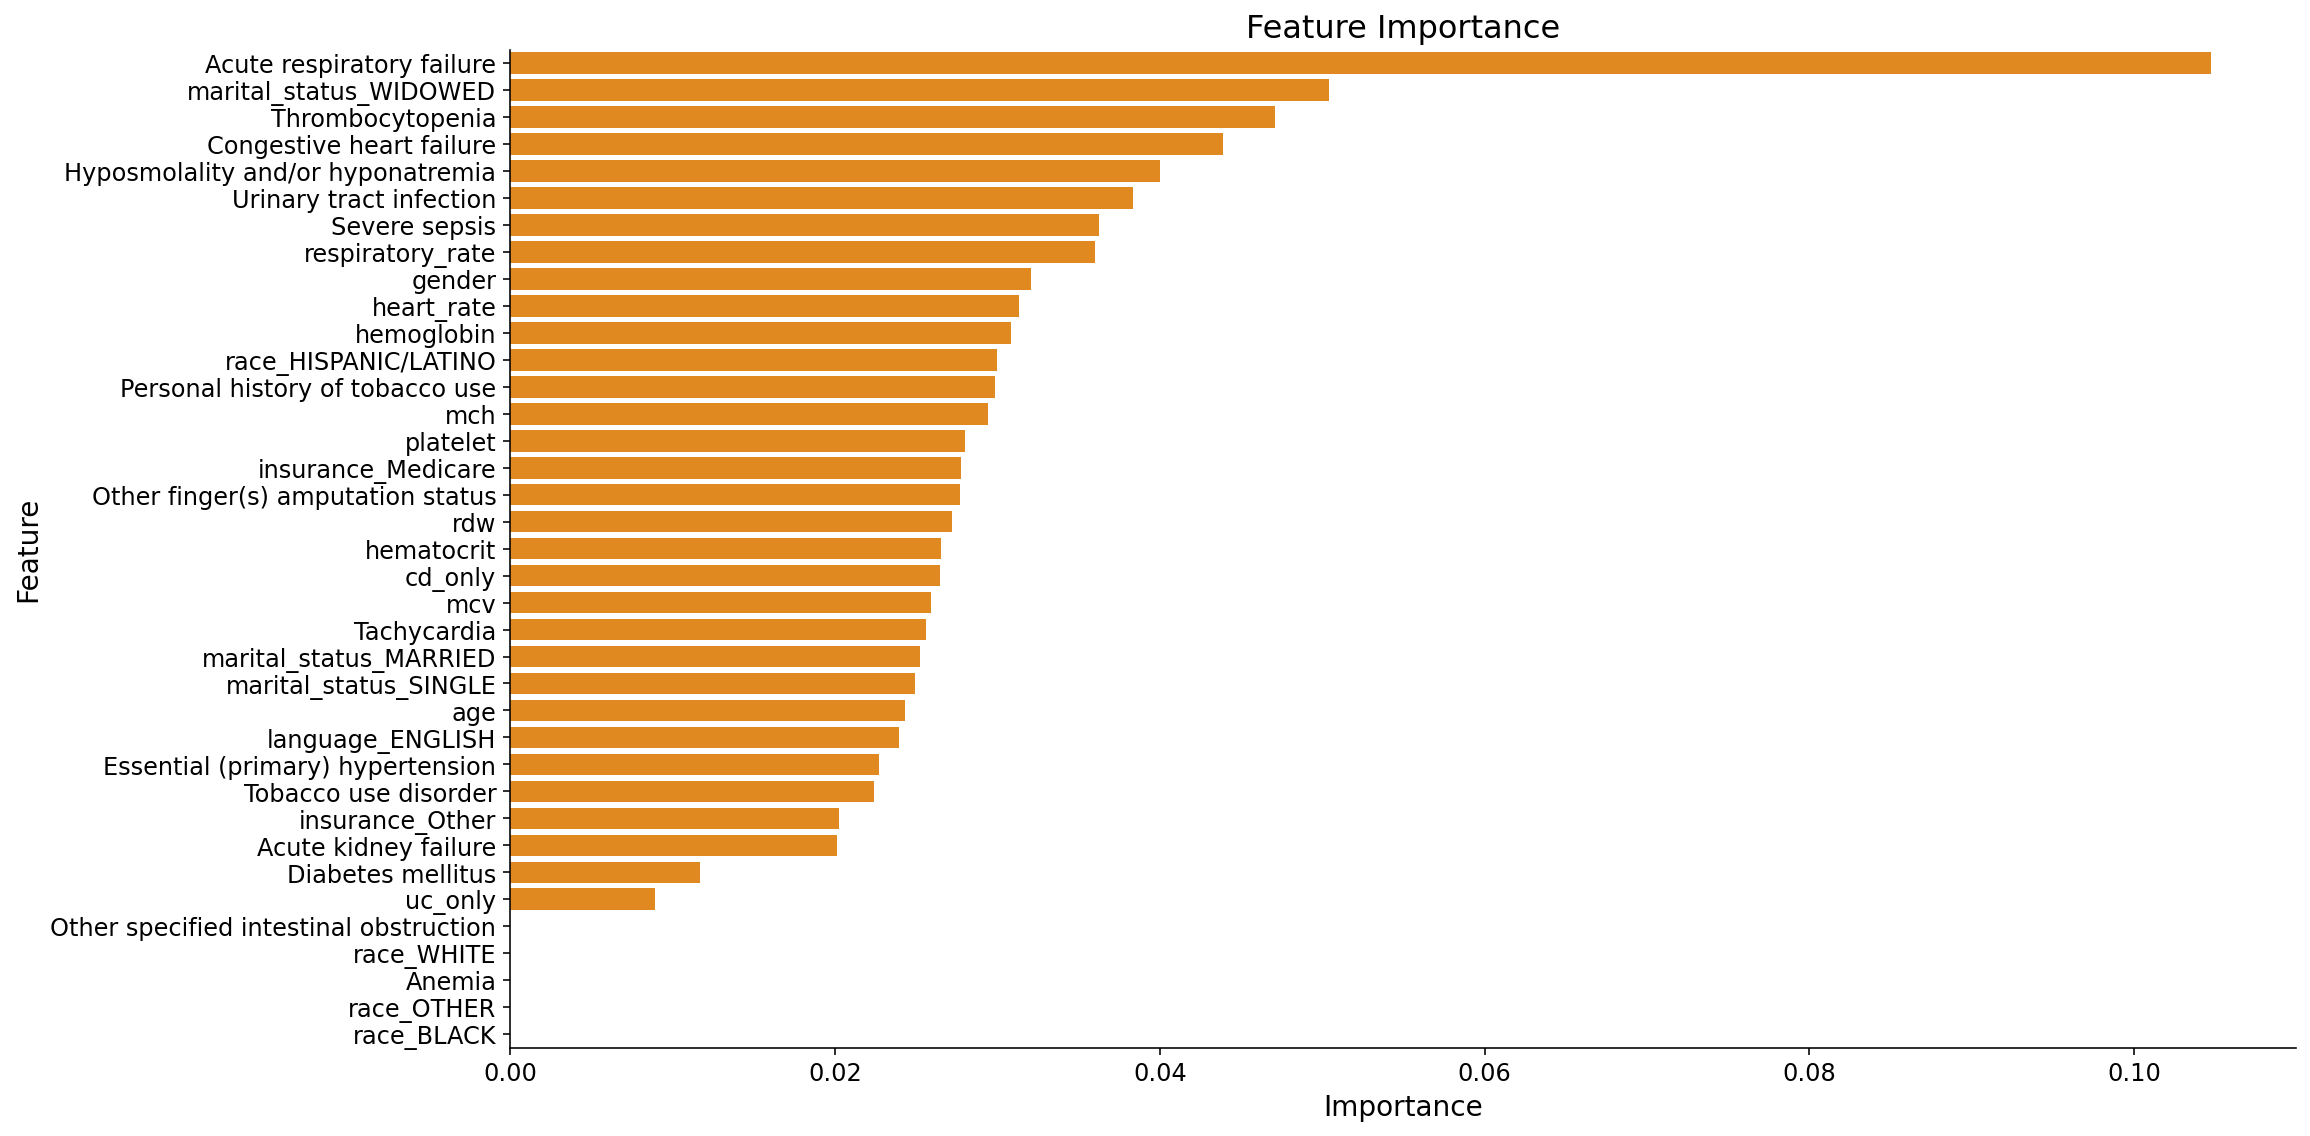

In [11]:
# Plot
plt.figure(figsize=(16, 9), dpi=144)  # 设置图表大小
sns.barplot(x='Importance', 
            y='index', 
            data=importance_df, 
            # palette='viridis',
            color='darkorange',
            # hue='index', 
            legend=False)  # 使用viridis颜色图

plt.title('Feature Importance', fontsize=16)  # 设置标题和字体大小
plt.xlabel('Importance', fontsize=14)  # 设置x轴标签和字体大小
plt.ylabel('Feature', fontsize=14)  # 设置y轴标签和字体大小
plt.xticks(fontsize=12)  # 设置x轴刻度的字体大小
plt.yticks(fontsize=12)  # 设置y轴刻度的字体大小
sns.despine()  # 移除上方和右方的边框线
plt.show()

In [12]:
importance_df.to_csv('./importance_df.csv', index=False)